In [1]:
# Gerekli kütüphaneleri yüklüyoruz
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.sparse import hstack, csr_matrix
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [2]:
# Veriyi yüklüyoruz
df = pd.read_csv('/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv')

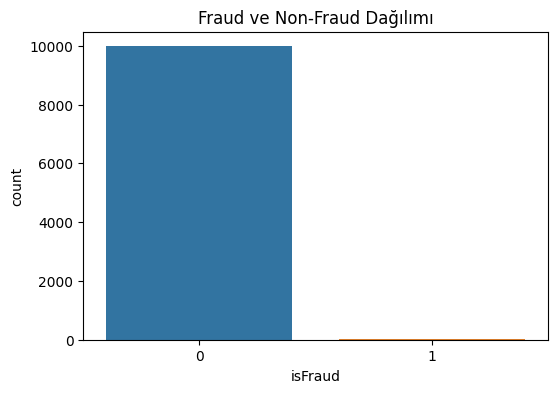

In [3]:
# Veriyi rastgele 10,000 örnekle sınırlıyoruz
df_sample = df.sample(n=10000, random_state=42)

# Hedef değişkenin dağılımını görselleştiriyoruz
plt.figure(figsize=(6, 4))
sns.countplot(data=df_sample, x='isFraud')
plt.title('Fraud ve Non-Fraud Dağılımı')
plt.show()

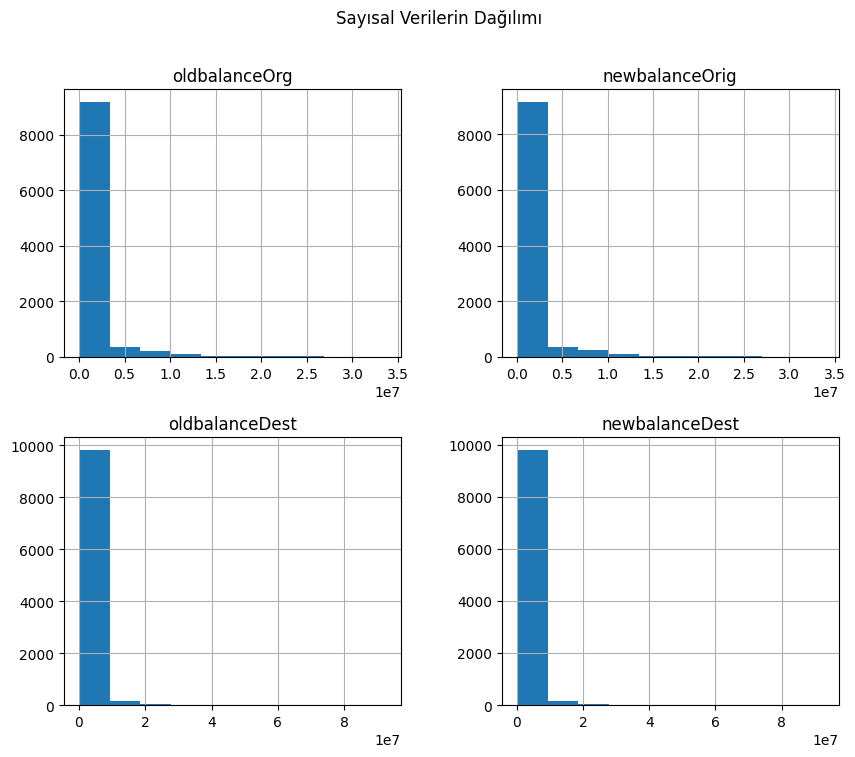

In [4]:
# Sayısal verilerin dağılımını incelemek için histogram çiziyoruz
df_sample[['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].hist(figsize=(10, 8))
plt.suptitle('Sayısal Verilerin Dağılımı')
plt.show()

In [5]:
# Kategorik sütunları belirliyoruz
categorical_columns = ['type', 'nameOrig', 'nameDest']
X_categorical = df_sample[categorical_columns]
X_numeric = df_sample.drop(columns=categorical_columns + ['isFraud'])

# Kategorik verileri OneHotEncoder ile dönüştürüyoruz
encoder = OneHotEncoder(sparse_output=False)
X_categorical_encoded = encoder.fit_transform(X_categorical)

# Sayısal verileri numpy array'e dönüştürüyoruz
X_numeric = X_numeric.values
X_numeric_sparse = csr_matrix(X_numeric)

# Kategorik ve sayısal verileri birleştiriyoruz
X_combined = hstack([X_numeric_sparse, X_categorical_encoded])

# Eğitim ve test setlerine bölüyoruz
X_train, X_test, y_train, y_test = train_test_split(X_combined, df_sample['isFraud'], test_size=0.2, random_state=42)

# SMOTE ile eğitim verisini dengeye getiriyoruz
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### Özellik Mühendisliği
Verinin daha iyi anlaşılması ve model performansının artırılması için bazı özellikler yeniden yapılandırıldı ve yeni özellikler türetildi.


### SMOTE Kullanımı
Veri setindeki sınıf dengesizliğini düzeltmek için SMOTE kullanıldı. Azınlık sınıfındaki örnekleri artırarak modelin bu sınıfı daha iyi öğrenmesi hedeflenmiştir. Bu sayede, dengesiz veri setlerinden kaynaklanan sorunlar en aza indirilmiştir.


### Veri Dengesizliği ile Mücadele
Fraud olan veriler, veri setinde nispeten daha az sayıda olduğu için SMOTE yöntemi kullanılarak bu dengesizlik giderilmeye çalışıldı. Bu sayede azınlık sınıfındaki örnekler artırılarak modelin bu sınıfı daha iyi öğrenmesi sağlandı.


---------------------------------

### Gözetimli Öğrenme

In [6]:
# ---------------- Gözetimli Öğrenme ---------------- #

# Lojistik Regresyon Modeli
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}
random_search_lr = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, n_iter=10, cv=3, n_jobs=-1, scoring='accuracy', random_state=42)
random_search_lr.fit(X_train_smote, y_train_smote)
best_lr = random_search_lr.best_estimator_

# En iyi Lojistik Regresyon modelini kullanarak çapraz doğrulama
cv_scores_lr = cross_val_score(best_lr, X_train_smote, y_train_smote, cv=3, scoring='accuracy')
print(f"Lojistik Regresyon Çapraz Doğrulama Ortalama Doğruluk Skoru: {cv_scores_lr.mean()}")

Lojistik Regresyon Çapraz Doğrulama Ortalama Doğruluk Skoru: 0.9303604816443848


In [7]:
# Random Forest Modeli
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
random_search_rf = RandomizedSearchCV(RandomForestClassifier(), param_grid_rf, n_iter=10, cv=3, n_jobs=-1, scoring='accuracy', random_state=42)
random_search_rf.fit(X_train_smote, y_train_smote)
best_rf = random_search_rf.best_estimator_

# En iyi Random Forest modelini kullanarak çapraz doğrulama
cv_scores_rf = cross_val_score(best_rf, X_train_smote, y_train_smote, cv=3, scoring='accuracy')
print(f"Random Forest Çapraz Doğrulama Ortalama Doğruluk Skoru: {cv_scores_rf.mean()}")

Random Forest Çapraz Doğrulama Ortalama Doğruluk Skoru: 1.0


### Model Seçimi
Logistic Regression ve Random Forest modelleri kullanıldı. Logistic Regression, basit ve yorumlanabilir yapısı nedeniyle tercih edilirken, Random Forest daha karmaşık veri ilişkilerini öğrenmek için kullanılmıştır.


-----------------------

### Gözetimsiz Öğrenme

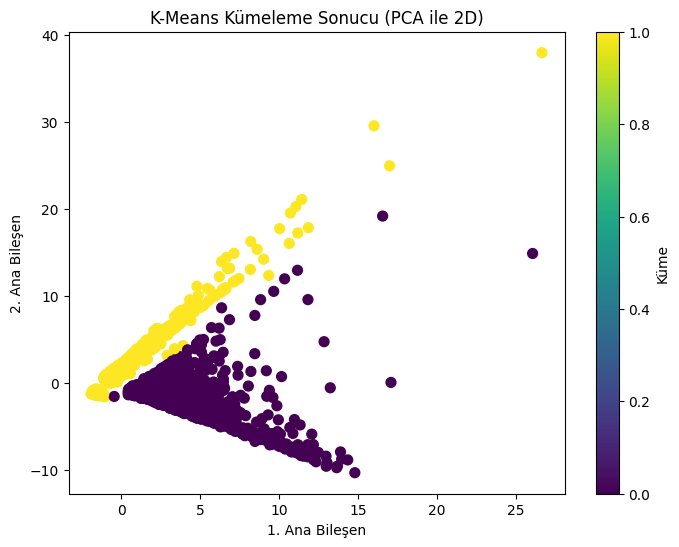

In [8]:
# ---------------- Gözetimsiz Öğrenme ---------------- #

# K-Means Kümeleme Modeli
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined.toarray())


kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_scaled)
y_kmeans = kmeans.labels_

# K-Means için PCA ile boyut indirgeme
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# K-Means Kümelerinin Görselleştirilmesi
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis', marker='o', s=50)
plt.title("K-Means Kümeleme Sonucu (PCA ile 2D)")
plt.xlabel("1. Ana Bileşen")
plt.ylabel("2. Ana Bileşen")
plt.colorbar(label='Küme')
plt.show()


K-Means Karışıklık Matrisi:
 [[2225 7756]
 [   1   18]]
DBSCAN Karışıklık Matrisi:
 [[   0    0    0]
 [9981    0    0]
 [  19    0    0]]


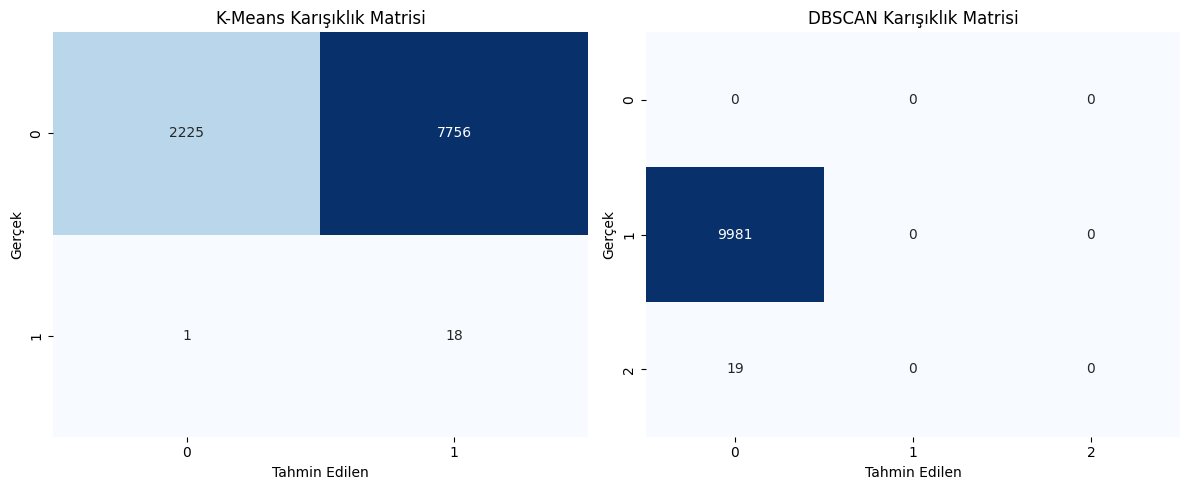

In [9]:
# DBSCAN Kümeleme Modeli
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_dbscan = dbscan.fit_predict(X_scaled)


# K-Means ve DBSCAN performanslarını karşılaştırma
# K-Means için Karışıklık Matrisi
cm_kmeans = confusion_matrix(df_sample['isFraud'], y_kmeans)
print("K-Means Karışıklık Matrisi:\n", cm_kmeans)

# DBSCAN için Karışıklık Matrisi
cm_dbscan = confusion_matrix(df_sample['isFraud'], y_dbscan)
print("DBSCAN Karışıklık Matrisi:\n", cm_dbscan)

# Grafiklerle gösterim
plt.figure(figsize=(12, 5))

# K-Means Karışıklık Matrisi
plt.subplot(1, 2, 1)
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('K-Means Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')

# DBSCAN Karışıklık Matrisi
plt.subplot(1, 2, 2)
sns.heatmap(cm_dbscan, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('DBSCAN Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')

plt.tight_layout()
plt.show()

### En iyi gözetimli öğrenme modeli ile en iyi gözetimsiz öğrenme modeli karşılaştırması

In [10]:

best_supervised_model = best_rf if cv_scores_rf.mean() > cv_scores_lr.mean() else best_lr
best_unsupervised_model = "K-Means" if cm_kmeans[1, 1] > cm_dbscan[1, 1] else "DBSCAN"
print(f"En iyi gözetimli öğrenme modeli: {best_supervised_model}")
print(f"En iyi gözetimsiz öğrenme modeli: {best_unsupervised_model}")

En iyi gözetimli öğrenme modeli: RandomForestClassifier()
En iyi gözetimsiz öğrenme modeli: K-Means


---

K-Means Doğruluk Skoru: 0.2243
Random Forest En İyi Model Doğruluk Skoru: 1.0
K-Means En İyi Model Doğruluk Skoru: 0.2243


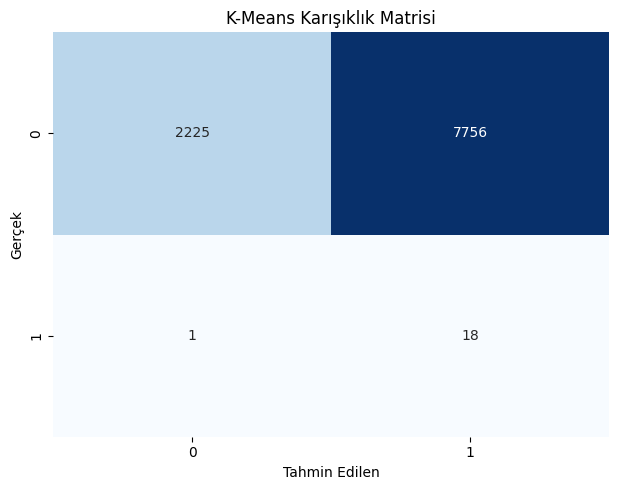


Performans Karşılaştırması:
Random Forest Doğruluk Skoru: 1.0
K-Means Doğruluk Skoru: 0.2243


In [11]:
# Performans metrikleri
accuracy_kmeans = accuracy_score(df_sample['isFraud'], y_kmeans)
print(f"K-Means Doğruluk Skoru: {accuracy_kmeans}")

# En iyi gözetimli öğrenme modeli ile gözetimsiz öğrenme modeli karşılaştırması
# Performansları karşılaştırmak için uygun metrikler kullanılır
best_supervised_model = best_rf
accuracy_rf = cv_scores_rf.mean()
print(f"Random Forest En İyi Model Doğruluk Skoru: {accuracy_rf}")

# Gözetimsiz öğrenme sonuçları
print(f"K-Means En İyi Model Doğruluk Skoru: {accuracy_kmeans}")

# Grafiklerle gösterim
plt.figure(figsize=(12, 5))

# K-Means Karışıklık Matrisi
plt.subplot(1, 2, 1)
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('K-Means Karışıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')

plt.tight_layout()
plt.show()

# Karşılaştırma Tablosu
print("\nPerformans Karşılaştırması:")
print(f"Random Forest Doğruluk Skoru: {accuracy_rf}")
print(f"K-Means Doğruluk Skoru: {accuracy_kmeans}")

------

### Sonuç
Bu projede, online ödeme dolandırıcılığını tespit etmek için Gözetimli öğrenme kapsamında Logistic Regression,Random Forest modelleri;Gözetimsiz öğrenme kapsamında ise K-means ve DBSCAN modelleri kullanıldı. Veri setindeki dengesizlik nedeniyle SMOTE uygulanarak azınlık sınıfındaki veriler dengelendi. Modellerin performansı karşılaştırıldığında, **Random Forest** modelinin dolandırıcılık tespitinde daha yüksek doğruluk ve F1 skoru sunduğu gözlemlendi. Logistic Regression ise daha basit ve yorumlanabilir olmasına rağmen, Random Forest modelinin derin öğrenme kapasitesi dolandırıcılığı daha etkin şekilde tespit etti.
